# Paper plots : subhalo masslos

This notebook shows how to make predictions for orbiting subhaloes, by using the tidal field at pericenter for evaluating the adiabatic-tides calculation

## Contents:

1) Tidal Fields: Showing the relation between radius and tidal fields for different scenarios

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os

import numpy as np
sys.path.append("../..")
import adiabatic_tides as at

from matplotlib.colors import LogNorm

if not os.path.exists("plots"):
    os.makedirs("plots")

h5cache = "../../caches/halo_grid.hdf5"

# Tidal Fields

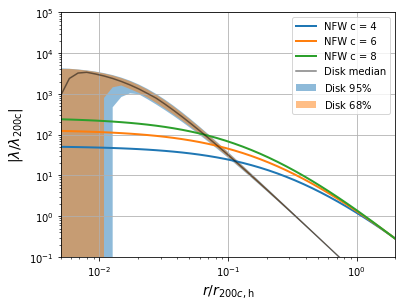

In [2]:
fig, axs = plt.subplots(1,1, sharex=True, figsize=(6,4.5))
axs = [axs]

for c in 4.,6.,8.:
    nfw_host = at.profiles.NFWProfile(conc=c, m200c=1e12)
    r = np.logspace(np.log10(5e-3),1) * nfw_host.r200c

    lvir = nfw_host.accr(nfw_host.r200c) / nfw_host.r200c
    Tev = nfw_host.tidal_eigval(r)

    p = axs[0].loglog(r/nfw_host.r200c, -Tev[0,:]/lvir, label="NFW c = %g" % c, lw=2)

tdisk_perc = at.potentials.tide_percentiles_miyamoto_nagai(r, nsamp=10000, percentile=(2.5,16,50,84,97.5)) #percentile=(0.15,2.5,16,50,84,97.5,99.85)

axs[0].fill_between(r/nfw_host.r200c, tdisk_perc[0,...,0]/np.abs(lvir),tdisk_perc[-1,...,0]/ np.abs(lvir), alpha=0.5, label=r"Disk $95$%")
axs[0].fill_between(r/nfw_host.r200c,tdisk_perc[1,...,0]/ np.abs(lvir), tdisk_perc[-2,...,0]/np.abs(lvir), alpha=0.5, label=r"Disk $68$%")
axs[0].loglog(r/nfw_host.r200c, np.abs(tdisk_perc[2,...,0]/lvir), color="black", label="Disk median", alpha=0.5)

for ax in axs:
    ax.grid("on")
    ax.set_ylabel(r"$|\lambda / \lambda_{\rm{200c}}|$", fontsize=14)
    ax.set_xlabel(r"$r / r_{200c, \rm{h}}$", fontsize=14)
    ax.legend()
    ax.set_xlim(5e-3,2)
    ax.set_ylim(1e-1,1e5)

fig.savefig("plots/host_tidal_fields_simplified.pdf", bbox_inches="tight")

# Create a 1D grid of module for later interpolation

In [3]:
# Calculate a 1d Grid of models. Note that each model takes about 5 minutes to calculate, making this about 5 hours in total
# However, we cache the results, so if you didn't delete the h5cache file that was included in the repository
# then this function should finish immediately

niter = 100
ls = np.logspace(-4, 2, 61)

mfrac = []
mfracvir = []

for i, l in enumerate(ls):
    nfw = at.profiles.NFWProfile(conc=10., m200c=1e6)
    prof_ad = at.profiles.AdiabaticProfile(nfw, tidfac_rs=l, niter=niter, h5cache=h5cache)
    prof_ad._initialize_tidal_radius()
    mfrac.append(prof_ad.self_m_of_r(prof_ad._rtid) / nfw.m_of_r(nfw.rs))

# Massloss in space $\frac{M}{M_s}(\lambda / \lambda_s, c)$ 
in this case there is not concentration dependence

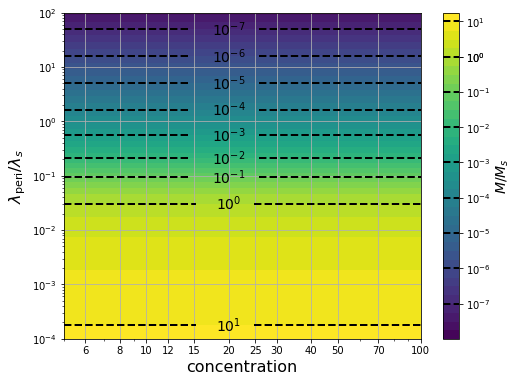

In [4]:
from matplotlib.colors import LogNorm

cs = [5., 7.5, 10., 15., 20., 25.,35.,50.,100]

cmesh, lsmesh = np.meshgrid(cs, ls, indexing="ij")

fig, ax = plt.subplots(1,1, figsize=(8,6))

im = ax.contourf(cmesh, lsmesh, mfrac*np.ones_like(cmesh), norm=LogNorm(10**-8, 12), levels=np.logspace(-8,1.25,38), cmap="viridis")
cb = plt.colorbar(im, ax=ax, orientation="vertical")

levels_mark = (1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1)
cs = ax.contour(cmesh, lsmesh, mfrac*np.ones_like(cmesh), colors="black", levels=levels_mark, linestyles="dashed", linewidths=2)
def fmt(x):
    return r"$10^{%d}$" % np.log10(x)
ax.clabel(cs, levels=levels_mark, fmt=fmt, fontsize=14)


for l in levels_mark:
    cb.ax.axhline(l, color="black", linestyle="dashed", lw=2)
cb.set_ticks(levels_mark + (1e0,))
cb.set_label(r"$M / M_{s}$", fontsize=14)

ax.set_xlim(5, 5e1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([6,8,10,12,15,20,25,30,40,50,70,100])
ax.set_xticklabels([6,8,10,12,15,20,25,30,40,50,70,100])

ax.set_xlabel("concentration", fontsize=16)
ax.set_ylabel(r"$\lambda_{\rm{peri}} / \lambda_s$", fontsize=16)
ax.grid("on")


fig.savefig("plots/massfrac_versus_ls_ms_1drel.pdf", bbox_inches="tight")

# Massloss in space $\frac{M}{M_{200c}}(\lambda, c)$ 
in this case there is a concentration dependence, since the concentration makes subhaloes more resiliant to the same **absolute** tidal field and the mass ratio includes the arbitrary truncation radius $M_{200c}$

In [5]:
# Here we set up some interpolation functions to evaluate subhaloes at arbitrary values of lambda/lambda_s
def get_msfrac(lsev, mode="all"):
    if mode == "all":
        return 10.**np.interp(np.log10(lsev), np.log10(ls),  np.log10(mfrac))
    else:
        return 10.**np.interp(np.log10(lsev), np.log10(ls),  np.log10(mfracvir))

def get_mvirfrac(conc, lvir, mode="all"):
    nfw = at.profiles.NFWProfile(conc=10., m200c=1e6) # Don't get confused, this concentration does not matter
    mvir_in_ms = nfw.m_of_r(conc*nfw.rs) / nfw.m_of_r(nfw.rs)
    lvir_in_ls = np.abs((nfw.accr(conc*nfw.rs) / (conc*nfw.rs)) / (nfw.accr(nfw.rs) / nfw.rs))

    l_in_ls = lvir * lvir_in_ls
    msfrac = get_msfrac(l_in_ls, mode=mode)

    return msfrac / mvir_in_ms

<a list of 6 text.Text objects>

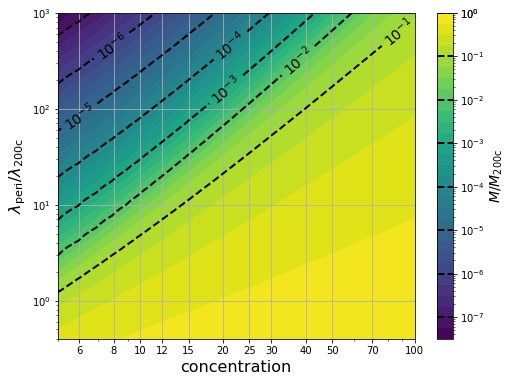

In [6]:
lvirs = np.logspace(-1, 3, 101)
cs = np.linspace(5, 100, 100)
#cs = [5, 10, 20, 30, 40, 50]
cmesh, lvmesh = np.meshgrid(cs, lvirs, indexing="ij")

mmesh = get_mvirfrac(cmesh, lvmesh)

#np.save("4ale/fig13_topright_cmesh.npy", cmesh)
#np.save("4ale/fig13_topright_lvirmesh.npy", lvmesh)
#np.save("4ale/fig13_topright_mfracmesh.npy", mmesh)

fig, ax = plt.subplots(1,1, figsize=(8,6))

im = ax.contourf(cmesh, lvmesh, mmesh, norm=LogNorm(10**-7.5, 1), levels=np.logspace(-7.5,0.,31), cmap="viridis")
cb = plt.colorbar(im, ax=ax, orientation="vertical")

levels_mark = (1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1)
cs = ax.contour(cmesh, lvmesh, mmesh, colors="black", levels=levels_mark, linestyles="dashed", linewidths=2)

for l in levels_mark:
    cb.ax.axhline(l, color="black", linestyle="dashed", lw=2)
cb.set_ticks(levels_mark + (1e0,))
cb.set_label(r"$M / M_{\rm{200c}}$", fontsize=14)

ax.set_xlim(5, 5e1)
ax.set_ylim(4e-1,None)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([6,8,10,12,15,20,25,30,40,50,70,100])
ax.set_xticklabels([6,8,10,12,15,20,25,30,40,50,70,100])


ax.set_xlabel("concentration", fontsize=16)
ax.set_ylabel(r"$\lambda_{\rm{peri}} / \lambda_{\rm{200c}}$", fontsize=16)
ax.grid("on")

def fmt(x):
    return r"$10^{%d}$" % np.log10(x)
ax.clabel(cs, levels=levels_mark, fmt=fmt, fontsize=14)


#fig.savefig("plots/massfrac_versus_lvir_mvir_1drel.pdf", bbox_inches="tight")

# Massloss in space $\frac{M}{M_{200c}}(r_p, c)$ for an NFW host
in this case there is a concentration dependence, since the concentration makes subhaloes more resiliant to the same **absolute** tidal field. Further, the tidal field is now expressed instead in the peri-center radius that is needed to have such a tidal field in an NFW host

In [7]:
nfw_host = at.profiles.NFWProfile(conc=6., m200c=1e12)

rperis = np.logspace(-2, 0.2, 101) * nfw_host.r200c
cs = np.linspace(5, 100, 100)
cmesh, rpmesh = np.meshgrid(cs, rperis, indexing="ij")

lvmesh = nfw_host.tidal_eigval(rpmesh)[0,:] / np.abs(nfw_host.accr(nfw_host.r200c)/nfw_host.r200c)
mmesh = get_mvirfrac(cmesh, lvmesh)

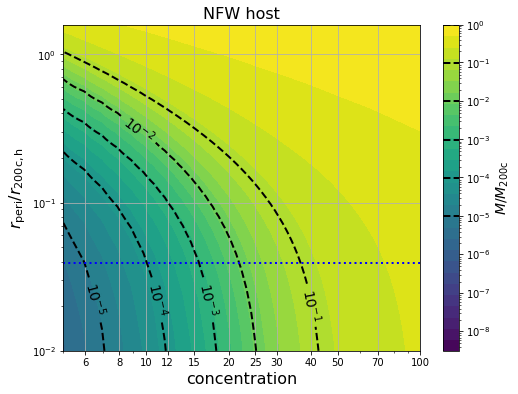

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

im = ax.contourf(cmesh, rpmesh/nfw_host.r200c, mmesh, #norm=LogNorm(10**-5.75, 1), levels=np.logspace(-5.75,0.,24), 
                 norm=LogNorm(10**-8.5, 1), levels=np.logspace(-8.5,0.,30), cmap="viridis")
cb = plt.colorbar(im, ax=ax, orientation="vertical")

levels_mark = (1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1)
cs = ax.contour(cmesh, rpmesh/nfw_host.r200c, mmesh, colors="black", levels=levels_mark, linestyles="dashed", linewidths=2)

for l in levels_mark:
    cb.ax.axhline(l, color="black", linestyle="dashed", lw=2)
cb.set_ticks((1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0))
cb.set_label(r"$M / M_{\rm{200c}}$", fontsize=14)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([6,8,10,12,15,20,25,30,40,50,70,100])
ax.set_xticklabels([6,8,10,12,15,20,25,30,40,50,70,100])

ax.set_title("NFW host", fontsize=16)
ax.set_xlabel("concentration", fontsize=16)
ax.set_ylabel(r"$r_{\rm{peri}} / r_{\rm{200c, h}}$", fontsize=16)
ax.grid("on")

def fmt(x):
    return r"$10^{%d}$" % np.log10(x)
ax.clabel(cs, levels=levels_mark, fmt=fmt, fontsize=14)

ax.axhline(8.2e-3/nfw_host.r200c, linestyle="dotted", color="blue", lw=2)

fig.savefig("plots/massfrac_versus_rperi_conc_1drel.pdf", bbox_inches="tight")

# Massloss in space $\frac{M}{M_{200c}}(r_p, c)$ for an NFW host + Disk
In this case the massloss is very different than for the pure NFW host, mostly because the relation between peri-center and tidal field has changed (compare the first plot in this notebook!)

In [9]:
nfw_host = at.profiles.NFWProfile(conc=6., m200c=1e12)

rperis = np.logspace(-2, 0.2, 101) * nfw_host.r200c

lam = at.potentials.tide_percentiles_miyamoto_nagai(rperis, nsamp=1000, percentile=50)[:,0]  + nfw_host.tidal_eigval(rperis)[0,:]

cs = np.linspace(5, 100, 100)
cmesh, lvmesh = np.meshgrid(cs, lam / np.abs(nfw_host.accr(nfw_host.r200c)/nfw_host.r200c), indexing="ij")
cmesh, rpmesh = np.meshgrid(cs, rperis, indexing="ij")

mmesh = get_mvirfrac(cmesh, lvmesh)

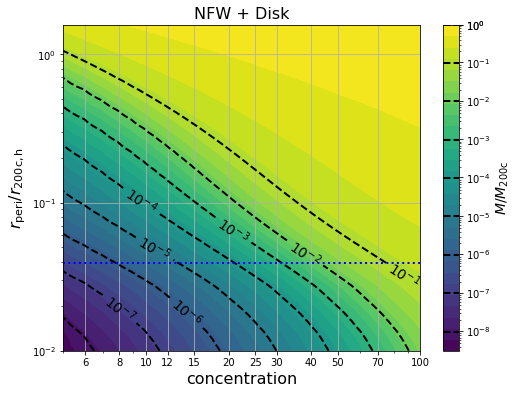

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

im = ax.contourf(cmesh, rpmesh/nfw_host.r200c, mmesh, norm=LogNorm(10**-8.5, 1), levels=np.logspace(-8.5,0.,30), cmap="viridis")
cb = plt.colorbar(im, ax=ax, orientation="vertical")

levels_mark = (1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0)
cs = ax.contour(cmesh, rpmesh/nfw_host.r200c, mmesh, colors="black", levels=levels_mark, linestyles="dashed", linewidths=2)

for l in levels_mark:
    cb.ax.axhline(l, color="black", linestyle="dashed", lw=2)
cb.set_ticks(levels_mark + (1e0,))
cb.set_label(r"$M / M_{\rm{200c}}$", fontsize=14)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([6,8,10,12,15,20,25,30,40,50,70,100])
ax.set_xticklabels([6,8,10,12,15,20,25,30,40,50,70,100])

ax.set_xlabel("concentration", fontsize=16)
ax.set_ylabel(r"$r_{\rm{peri}} / r_{\rm{200c, h}}$", fontsize=16)
ax.grid("on")

ax.set_title("NFW + Disk", fontsize=16)

def fmt(x):
    return r"$10^{%d}$" % np.log10(x)
ax.clabel(cs, levels=levels_mark, fmt=fmt, fontsize=14)

ax.axhline(8.2e-3/nfw_host.r200c, linestyle="dotted", color="blue", lw=2)

fig.savefig("plots/massfrac_disk_versus_rperi_conc_1drel.pdf", bbox_inches="tight")